# 0. Importing Necessary Packages

In [1]:
# Printing the information of Python, IPython, OS, and the generation date.
# Before running this, you have to install version_information module with "pip install version_information".
%load_ext version_information
%version_information

Software versions
Python 2.7.17 64bit [GCC 7.3.0]
IPython 5.8.0
OS Linux 5.8.18 100.fc31.x86_64 x86_64 with fedora 31 Thirty_One
Sat Apr 30 22:33:19 2022 KST

In [2]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'pandas', 'astropy', 'pyraf']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.16.5
matplotlib: ver 2.2.3
pandas: ver 0.24.2
astropy: ver 2.0.16
pyraf: ver 2.1.15


In [3]:
# Matplotlib backend
%matplotlib notebook

# Importing necessary modules
import time
import numpy as np
import glob, os, copy
from matplotlib import pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

current_dir = os.getcwd()    # Current working directory
login_file = "/data/jlee/DATA/TA/2022A/login.cl"    # Please give the absolute path of your 'login.cl' file

# Reading 'login.cl' file
f = open(login_file, "r")
ll = f.readlines()
f.close()

# Finding the string for home directory in 'login.cl' file
line_homedir = np.argwhere(pd.Series(ll).str.startswith("set\thome\t\t=").values)[0][0]
idx_start = ll[line_homedir].find('"')
idx_end = ll[line_homedir].find('"', idx_start+1)
dir_iraf = ll[line_homedir][idx_start+1:idx_end]    # Home directory recoded in the 'login.cl' file
print(dir_iraf)    # For check

# Importing IRAF
os.chdir(dir_iraf)
from pyraf import iraf
os.chdir(current_dir)

/data/jlee/DATA/TA/2022A/


# 1. Displaying the Images

In [4]:
dir_img = "Combined_images/"
imglist = [dir_img+"M105-g.fits", dir_img+"M105-i.fits",
           dir_img+"M100-g.fits", dir_img+"M100-i.fits"]
n_img = len(imglist)
imglist

['Combined_images/M105-g.fits',
 'Combined_images/M105-i.fits',
 'Combined_images/M100-g.fits',
 'Combined_images/M100-i.fits']

In [5]:
# You can also run this command in terminal.
ds9_options = "-scalemode zscale -scale lock yes -frame lock image "
names = ""
for i in np.arange(n_img):
    names += imglist[i]+" "
ds9_command = "ds9 "+ds9_options+names+"&"
print('Running "'+ds9_command+'" in the terminal...')
os.system(ds9_command)

Running "ds9 -scalemode zscale -scale lock yes -frame lock image Combined_images/M105-g.fits Combined_images/M105-i.fits Combined_images/M100-g.fits Combined_images/M100-i.fits &" in the terminal...


0

# 2. Running IRAF/Ellipse Task 

In [6]:
# IRAF/ellipse task is in the STSDAS package (IRAF external package)
iraf.stsdas()
iraf.stsdas.analysis()
iraf.stsdas.analysis.isophote()



      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |
      |                   STSDAS Version 3.18.3                    |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      |                                                            |
      +------------------------------------------------------------+


In [7]:
# For viewing help file of "ellipse" task
### IRAF.net website has recently stop its service... :(
### But you can still see the detailed description of input parameters of any tasks (but not so convenient) 
iraf.epar("ellipse")
# You have to see the detailed definition of each parameter in geompar, controlpar, samplepar, and magpar.
# iraf.epar("[TASK_NAME]")
### Click "[TASK_NAME] help" for viewing the parameter editor help browser

In [14]:
def fit_ellipse(input_image, output_table=None, interactive=False,
                model_image=None, residual_image=None, display=False, data_file=None,
                x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,  # geompar
                minsma=0.0, maxsma=50.0, step=1.0, linear=False, recenter=False,  # geompar
                minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,  # controlpar
                usclip=3.0, lsclip=3.0, nclip=0,  # samplepar
                mag0=25.0,  # magpar
                backgr=0.0, interp='linear'):  # bmodel

    '''
    # --- basic input parameters --- #
    input_image - input image name ('[FILENAME].fits')
    output_table - output table name (default: '[FILENAME].tab')
    interactive - interactive (boolean, default: False)
    model_image - output model image (default: '[FILENAME]_mod.fits')
    residual_image - output residual image (default: '[FILENAME]_res.fits')
    data_file - output data file (default: '[FILENAME].dat')
    display - display the results or not? (boolean, default: False)
    
    # --- geompar set --- #
    x0, y0 - initial isophote center X, Y [pixel]
    ellip0, pa0 - initial ellipticity, position angle [degree]
    sma0 - initial semi-major axis (SMA) length [pixel]
    minsma - minimum SMA length for fitting [pixel] (default: 0.0)
    maxsma - maximum SMA length for fitting [pixel]
    step - SMA step between successive ellipses [pixel]
    linear - linear SMA step for fitting? (boolean, default: False)
    recenter - do you allow to re-center x0 & y0? (boolean, default: False)
    
    # --- controlpar set --- #
    minit - minimum iteration number at each step of SMA (default: 10)
    maxit - maximum iteration number at each step of SMA (default: 100)
    hcenter - do you want to hold center fixed? (boolean, default: False)
    hellip - do you want to hold ellipticity fixed? (boolean, default: False)
    hpa - do you want to hold position angle fixed? (boolean, default: False)
    
    # --- samplepar set --- #
    usclip - upper sigma-clip criterion (default: 3)
    lsclip - lower sigma-clip criterion (default: 3)
    nclip - iteration number for the sigma clipping (default: 0)
    
    # --- magpar set --- #
    mag0 - magnitude zeropoint (default: 25.0)
    
    # --- bmodel parameter set --- #
    backgr - background level for making model image (default: 0.0)
    interp - interpolation algorithm for model image ('nearest' OR 'linear' OR 'poly3' OR 'spline', default: 'linear')    
    '''
    
    iname = input_image.split('.fits')[0].split('/')[-1]    # Image name
    if (output_table is None):
        output_table = iname+'.tab'    # Output table name
    if (model_image is None):
        model_image = iname+'_mod.fits'    # Output model image name
    if (residual_image is None):
        residual_image = iname+'_res.fits'    # Output residual image name
    if (data_file is None):
        data_file = iname+'.dat'    # Output data file name 

    # Running IRAF/ellipse task
    os.system("rm -rfv "+output_table+" colnames.lis "+data_file)  # Reset by removing the output data
    kwargs = {"x0":x0, "y0":y0, "ellip0":ellip0, "pa0":pa0, "sma0":sma0,
              "minsma":minsma, "maxsma":maxsma, "step":step, "linear":"no", "recenter":"no",
              "minit":minit, "maxit":maxit, "hcenter":"no", "hellip":"no", "hpa":"no",
              "integrmode":"bi-linear", "usclip":usclip, "lsclip":lsclip, "nclip":nclip,
              "mag0":mag0, "refer":1.0E-5, "zerolevel":0.0}
    iraf.ellipse(input=input_image, output=output_table, interactive=interactive,
                 **kwargs)
    
    # Making model, residual images
    os.system("rm -rfv "+model_image+" "+residual_image)  # Reset by removing the output images
    iraf.bmodel(table=output_table, output=model_image, parent=input_image,
                backgr=backgr, interp=interp)    # bmodel task for model image
    
    iraf.imarith(input_image, "-", model_image, residual_image)    # input - model = residual
    
    if display:    # if display == True, DS9 will display input, model, and residual images.
        opt = " -scalemode zscale -scale lock yes -frame lock image "
        opt += " -tile grid mode manual -tile grid layout 3 1 "
        os.system("ds9 "+opt+input_image+" "+model_image+" "+residual_image+"&")
    
    # Reading output results
    ### output_table is not directly readable because it is a binary-format file :( 
    iraf.tlcol(output_table, nlist=1, Stdout='colnames.lis')    # Extracting column names
    iraf.tdump(table=output_table, columns="@colnames.lis", datafile=data_file)    # Making ASCII data file
    
    f = open("colnames.lis", "r")
    cc = f.readlines()
    f.close()

    colnames = []
    for line in cc:
        if not (line[0] == '#'):
            colnames.append(line.split(' ')[0])
#     print(colnames)    # column names array
    
    iso_tbl = np.genfromtxt(data_file, encoding="ascii", names=colnames)    # Reading data
    iso_df = pd.DataFrame(iso_tbl)
#     print(iso_df)    # output result data frame
    
    return iso_df

In [15]:
# For g-band image of M105
imgname = "Combined_images/M105-g.fits"
x_center, y_center = 455.0, 455.0    # depending on your object & image size
r0 = 420.0    # outer boundary for sky estimation (up to you)
rmax = 470.0    # maximum SMA (up to you)

# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = 3.0*med - 2.0*avg, std
print(sky_val, sky_sig)
# ---------- #

kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.05, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.05,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":2, "mag0":22.5,    # SDSS magnitue zeropoint: ~ 22.5 mag (https://www.sdss.org/dr12/algorithms/magnitudes/)
          "backgr":sky_val, "interp":"linear"}  # Here you can change input (default) parameter if needed!

iso_df = fit_ellipse(imgname, display=True, **kwargs)

# def fit_ellipse(input_image, output_table=None, interactive=False,
#                 model_image=None, residual_image=None, display=False, data_file=None,
#                 x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,  # geompar
#                 minsma=0.0, maxsma=50.0, step=1.0, linear=False, recenter=False,  # geompar
#                 minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,  # controlpar
#                 usclip=3.0, lsclip=3.0, nclip=0,  # samplepar
#                 mag0=25.0,  # magpar
#                 backgr=0.0, interp='linear'):  # bmodel

(0.02016184872497758, 0.015442665365112712)
Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00    33.55(  0.14) 0.084(0.003)  70.25( 1.16) 0.018   30   0    20    0
   5.25    32.44(  0.14) 0.087(0.003)  71.93( 1.06) 0.015   32   0    10    0
   5.51    31.26(  0.13) 0.087(0.003)  72.97( 0.97) 0.014   33   0    10    0
   5.79    30.11(  0.12) 0.088(0.002)  73.48( 0.83) 0.012   35   0    10    0
   6.08    28.95(  0.12) 0.089(0.002)  73.43( 0.81) 0.011   37   0    10    0
   6.38    27.83(  0.11) 0.090(0.002)  73.68( 0.71) 0.010   39   0    10    0
   6.70    26.70(  0.09) 0.093(0.002)  73.93( 0.57) 0.010   40   0    10    0
   7.04    25.53(  0.10) 0.091(0.002)  74.14( 0.62) 0.010   42   0    10    0
   7.39    24.42(  0.12) 0.0

   3.38    42.40(  0.23) 0.101(0.007)  68.47( 2.19) 0.032   21   0    10    0
   3.22    43.31(  0.26) 0.098(0.008)  66.60( 2.71) 0.043   20   0    10    0
   3.07    44.33(  0.24) 0.107(0.008)  68.21( 2.49) 0.045   19   0    10    0
   2.92    45.09(  0.27) 0.095(0.010)  66.66( 3.34) 0.049   18   0    10    0
   2.78    46.05(  0.28) 0.103(0.011)  67.61( 3.40) 0.055   17   0    10    0
   2.65    46.80(  0.25) 0.096(0.011)  65.38( 3.55) 0.061   16   0    10    0
   2.53    47.56(  0.29) 0.097(0.013)  64.34( 4.31) 0.065   16   0    10    0
   2.41    48.36(  0.31) 0.105(0.016)  70.59( 4.89) 0.085   15   0    10    0
   2.29    49.04(  0.33) 0.103(0.020)  68.83( 5.94) 0.101   14   0    10    0
   2.18    49.76(  0.35) 0.107(0.022)  68.89( 6.20) 0.100   13   0    10    0
   2.08    50.28(  0.35) 0.090(0.023)  68.89( 7.69) 0.107   13   0   100    2
   1.98    50.81(  0.35) 0.090(0.025)  68.89( 8.70) 0.122   13   0   100    2
   1.88    51.29(  0.32) 0.090(0.028)  68.89( 9.45) 0.135   13  

In [16]:
iso_df.head(10)

,SMA,INTENS,INT_ERR,PIX_VAR,RMS,ELLIP,ELLIP_ERR,PA,PA_ERR,X0,...,A4,A4_ERR,B4,B4_ERR,NDATA,NFLAG,NITER,STOP,A_BIG,SAREA
0,0.000000,57.12299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,454.8997,...,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN
1,0.504747,56.10192,0.032908,0.167800,0.118652,0.071857,0.099802,43.02824,42.62660,454.8997,...,-0.036725,0.023676,-0.116903,0.057866,13.0,0.0,16.0,0.0,0.006130,2.0
2,0.529984,56.04976,0.035201,0.179490,0.126919,0.071857,0.100895,43.74089,43.09356,454.8952,...,-0.032159,0.022620,-0.116871,0.058860,13.0,0.0,11.0,0.0,0.010091,2.0
3,0.556484,55.99618,0.036456,0.185888,0.131443,0.071857,0.100271,39.62644,42.82674,454.8922,...,-0.060673,0.032357,-0.117451,0.058002,13.0,0.0,100.0,2.0,0.007086,2.0
4,0.584308,55.93932,0.038493,0.196277,0.138789,0.071857,0.100414,39.62644,42.88792,454.8835,...,-0.061087,0.032627,-0.116527,0.057576,13.0,0.0,100.0,2.0,0.012193,2.0
5,0.613523,55.87871,0.041089,0.209512,0.148147,0.071857,0.101904,39.62644,43.52449,454.8835,...,-0.062590,0.033747,-0.119622,0.060052,13.0,0.0,100.0,2.0,0.009148,2.0
6,0.644199,55.82635,0.042826,0.218371,0.154412,0.086230,0.099486,39.62644,35.67504,454.8706,...,-0.061573,0.033167,-0.116157,0.057984,13.0,0.0,100.0,2.0,0.016894,2.0
7,0.676409,55.75992,0.045308,0.231029,0.163362,0.086230,0.100967,39.62644,36.20591,454.8706,...,-0.063097,0.034130,-0.119275,0.060130,13.0,0.0,100.0,2.0,0.013662,2.0
8,0.710230,55.68998,0.047930,0.244398,0.172816,0.086230,0.101291,39.62644,36.32220,454.8644,...,-0.064294,0.034718,-0.118915,0.060198,13.0,0.0,100.0,2.0,0.015475,2.0
9,0.745741,55.61703,0.050682,0.258427,0.182735,0.086230,0.101663,39.62644,36.45551,454.8559,...,-0.063653,0.034684,-0.118901,0.060546,13.0,0.0,100.0,2.0,0.019212,2.0


In [17]:
iso_df_g = copy.deepcopy(iso_df)

In [18]:
# For i-band image of M105
imgname = "Combined_images/M105-i.fits"
x_center, y_center = 455.0, 455.0    # depending on your object & image size
r0 = 420.0    # outer boundary for sky estimation (up to you)
rmax = 470.0    # maximum SMA (up to you)

# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = 3.0*med - 2.0*avg, std
print(sky_val, sky_sig)
# ---------- #

kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.05, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.05,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":2, "mag0":22.5,    # SDSS magnitue zeropoint: ~ 22.5 mag (https://www.sdss.org/dr12/algorithms/magnitudes/)
          "backgr":sky_val, "interp":"linear"}  # Here you can change input (default) parameter if needed!

iso_df = fit_ellipse(imgname, display=True, **kwargs)
iso_df_i = copy.deepcopy(iso_df)

(0.06471018850046456, 0.04273360519144418)
Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00   106.06(  2.78) 0.050(0.004) -79.83( 2.29) 0.087   31   0   100    2
   5.25   102.10(  2.61) 0.050(0.003)  53.38( 1.96) 0.082   33   0   100    2
   5.51    98.08(  2.66) 0.050(0.003)  53.38( 1.87) 0.083   34   0   100    2
   5.79    94.19(  2.62) 0.050(0.003)  53.38( 1.74) 0.079   36   0   100    2
   6.08    90.25(  2.61) 0.050(0.003)  53.38( 1.94) 0.077   38   0   100    2
   6.38    86.39(  2.53) 0.050(0.003)  53.38( 1.66) 0.075   39   0   100    2
   6.70    82.62(  2.48) 0.050(0.003)  53.38( 1.58) 0.073   41   0   100    2
   7.04    78.95(  2.37) 0.050(0.003)  53.38( 1.59) 0.070   43   0   100    2
   7.39    75.37(  2.27) 0.05

   3.38   129.12(  5.09) 0.310(0.074)  15.41( 8.45) 0.504   18   0    20    0
   3.22   126.27(  3.08) 0.515(0.063)  77.43( 5.04) 0.578   15   0    30    0
   3.07   127.44(  2.10) 0.524(0.042)  80.79( 3.42) 0.597   15   0    10    0
   2.92   127.70(  2.21) 0.504(0.049)  79.37( 3.92) 0.548   14   0    10    0
   2.78   128.97(  2.42) 0.507(0.046)  79.82( 3.66) 0.374   14   0    10    0
   2.65   129.74(  2.18) 0.503(0.040)  81.12( 3.27) 0.388   14   0    10    0
   2.53   129.76(  1.77) 0.476(0.042)  81.87( 3.56) 0.441   14   0    10    0
   2.41   129.23(  1.34) 0.429(0.048)  82.15( 4.13) 0.536   13   0    10    0
   2.29   130.33(  1.25) 0.427(0.038)  83.00( 3.34) 0.365   13   0    10    0
   2.18   131.50(  1.19) 0.429(0.028)  83.60( 2.43) 0.206   13   0    10    0
   2.08   132.60(  1.09) 0.432(0.027)  83.78( 2.32) 0.210   13   0    10    0
   1.98   133.72(  1.02) 0.438(0.027)  83.94( 2.30) 0.213   13   0    10    0
   1.88   134.63(  0.97) 0.439(0.027)  84.31( 2.35) 0.218   13  

<IPython.core.display.Javascript object>


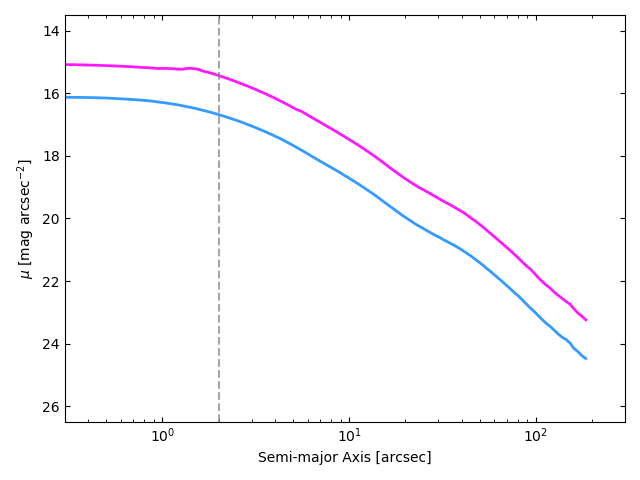

In [13]:
# ----- Pixel scale & Magnitude zeropoint ----- #
pixel_scale = 0.396    # arcsec/pixel (SDSS image)
mag_zeropoint = 22.5    # SDSS magnitude zeropoint (just for example)
### If you use other images, then you should revise these!

# Unit conversion
r_sma = iso_df_g['SMA'].values * pixel_scale    # pixel to arcsec
mu_g = mag_zeropoint-2.5*np.log10(iso_df_g['INTENS'].values)-2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
mu_i = mag_zeropoint-2.5*np.log10(iso_df_i['INTENS'].values)-2.5*np.log10(pixel_scale**(-2))

fig, ax = plt.subplots()
ax.plot(r_sma, mu_g, '-', color='dodgerblue', linewidth=2.0, alpha=0.9)
ax.plot(r_sma, mu_i, '-', color='magenta', linewidth=2.0, alpha=0.9)
ax.axvline(2.0, 0, 1, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)
ax.set_xlim([0.3, 300])
ax.set_xscale('log')
ax.set_ylim([26.5, 13.5])
ax.set_xlabel("Semi-major Axis [arcsec]")
ax.set_ylabel(r"$\mu$ [mag ${\rm arcsec^{-2}}$]")
plt.tight_layout()

In [37]:
# For g-band image of M100
imgname = "Combined_images/M100-g.fits"
x_center, y_center = 455.0, 455.0    # depending on your object & image size
rmax = 470.0    # maximum SMA (up to you)

kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.05, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.05,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":2, "mag0":22.5,    # SDSS magnitue zeropoint: ~ 22.5 mag (https://www.sdss.org/dr12/algorithms/magnitudes/)
          "backgr":0.05, "interp":"linear"}  # Here you can change input (default) parameter if needed!

iso_df = fit_ellipse(imgname, display=True, **kwargs)
iso_df2_g = copy.deepcopy(iso_df)

Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00     6.67(  0.64) 0.186(0.062) -83.61(10.90) 0.351   29   0   100    2
   5.25     6.50(  0.62) 0.204(0.068) -81.86(10.89) 0.411   30   0   100    2
   5.51     6.31(  0.61) 0.213(0.068) -81.86(10.38) 0.455   31   0   100    2
   5.79     6.11(  0.64) 0.213(0.078) -81.86(11.73) 0.593   32   0   100    2
   6.08     5.95(  0.69) 0.213(INDEF) -81.86(INDEF) 0.615   34   0     1    4
   6.38     5.81(  0.77) 0.213(INDEF) -81.86(INDEF) 0.738   36   0     1    4
   6.70     5.69(  0.83) 0.213(INDEF) -81.86(INDEF) 0.823   38   0     1    4
   7.04     5.55(  0.84) 0.213(INDEF) -81.86(INDEF) 1.030   39   0     1    4
   7.39     5.45(  0.90) 0.213(INDEF) -81.86(INDEF) 1.080   41   0     1

   3.22     9.35(  0.40) 0.200(0.032)  54.24( 5.07) 0.180   18   0    10    0
   3.07     9.76(  0.37) 0.214(0.029)  55.47( 4.34) 0.177   17   0    10    0
   2.92    10.17(  0.35) 0.225(0.025)  54.79( 3.83) 0.178   17   0    12    0
   2.78    10.56(  0.34) 0.228(0.025)  54.24( 3.66) 0.173   16   0    10    0
   2.65    10.91(  0.30) 0.227(0.022)  51.73( 3.25) 0.166   15   0    10    0
   2.53    11.34(  0.33) 0.229(0.025)  52.05( 3.64) 0.156   14   0    10    0
   2.41    11.74(  0.29) 0.234(0.022)  50.21( 3.19) 0.143   14   0    10    0
   2.29    12.19(  0.29) 0.247(0.024)  50.21( 3.15) 0.162   13   0   100    2
   2.18    12.59(  0.28) 0.251(0.025)  52.29( 3.29) 0.149   13   0    10    0
   2.08    12.93(  0.26) 0.244(0.023)  52.75( 3.18) 0.152   13   0    10    0
   1.98    13.30(  0.27) 0.242(0.024)  51.58( 3.30) 0.156   13   0    10    0
   1.88    13.64(  0.26) 0.237(0.025)  50.20( 3.48) 0.158   13   0    10    0
   1.79    13.95(  0.24) 0.231(0.024)  49.27( 3.48) 0.156   13  

In [38]:
# For i-band image of M100
imgname = "Combined_images/M100-i.fits"
x_center, y_center = 455.0, 455.0    # depending on your object & image size
rmax = 470.0    # maximum SMA (up to you)

kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.05, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.05,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":2, "mag0":22.5,    # SDSS magnitue zeropoint: ~ 22.5 mag (https://www.sdss.org/dr12/algorithms/magnitudes/)
          "backgr":0.18, "interp":"linear"}  # Here you can change input (default) parameter if needed!

iso_df = fit_ellipse(imgname, display=True, **kwargs)
iso_df2_i = copy.deepcopy(iso_df)

Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.00    21.96(  1.00) 0.189(0.029) -78.53( 4.95) 0.169   29   0    20    0
   5.25    21.35(  1.00) 0.204(0.029) -77.54( 4.69) 0.177   30   0    10    0
   5.51    20.76(  1.00) 0.220(0.029) -76.64( 4.32) 0.180   31   0    10    0
   5.79    20.21(  1.03) 0.236(0.029) -75.52( 4.10) 0.183   32   0    10    0
   6.08    19.69(  1.04) 0.254(0.029) -74.96( 3.80) 0.182   33   0    10    0
   6.38    19.14(  1.04) 0.270(0.030) -73.90( 3.68) 0.191   34   0   100    2
   6.70    18.63(  1.04) 0.283(0.027) -73.45( 3.32) 0.182   36   0    10    0
   7.04    18.09(  1.03) 0.297(0.027) -72.99( 3.16) 0.187   37   0    10    0
   7.39    17.68(  1.04) 0.318(0.026) -72.99( 2.84) 0.183   38   0    10

   3.22    29.35(  0.52) 0.092(0.016) -87.61( 5.33) 0.096   20   0    10    0
   3.07    30.34(  0.56) 0.080(0.017) -88.13( 6.32) 0.086   19   0    10    0
   2.92    31.58(  0.51) 0.085(0.015)  88.77( 5.53) 0.087   18   0    10    0
   2.78    32.59(  0.59) 0.072(0.018)  89.71( 7.40) 0.088   17   0    12    0
   2.65    33.87(  0.65) 0.071(0.020)  87.81( 8.15) 0.093   16   0    10    0
   2.53    35.46(  0.64) 0.075(0.016)  87.81( 6.73) 0.096   16   0    20    0
   2.41    36.91(  0.56) 0.074(0.014)  86.86( 5.79) 0.094   15   0    10    0
   2.29    38.45(  0.37) 0.067(0.009)  86.18( 4.05) 0.093   14   0    10    0
   2.18    40.30(  0.38) 0.084(0.009)  88.05( 3.34) 0.093   14   0    11    0
   2.08    41.56(  0.29) 0.070(0.008)  88.31( 3.34) 0.106   13   0    10    0
   1.98    43.16(  0.46) 0.071(0.012)  87.12( 5.31) 0.102   13   0    10    0
   1.88    44.65(  0.65) 0.060(0.017)  85.85( 8.74) 0.095   13   0    10    0
   1.79    46.10(  0.90) 0.047(0.024)  83.76(15.16) 0.109   13  

<IPython.core.display.Javascript object>


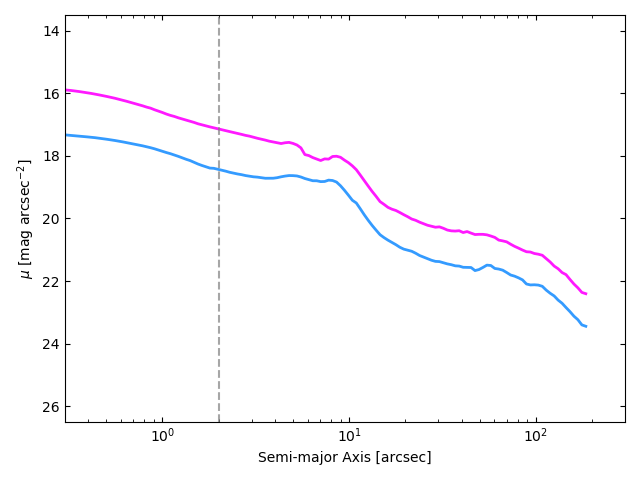

In [39]:
# Unit conversion
r_sma2 = iso_df2_g['SMA'].values * pixel_scale    # pixel to arcsec
mu_g2 = mag_zeropoint-2.5*np.log10(iso_df2_g['INTENS'].values)-2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
mu_i2 = mag_zeropoint-2.5*np.log10(iso_df2_i['INTENS'].values)-2.5*np.log10(pixel_scale**(-2))

fig, ax = plt.subplots()
ax.plot(r_sma2, mu_g2, '-', color='dodgerblue', linewidth=2.0, alpha=0.9)
ax.plot(r_sma2, mu_i2, '-', color='magenta', linewidth=2.0, alpha=0.9)
ax.axvline(2.0, 0, 1, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)
ax.set_xlim([0.3, 300])
ax.set_xscale('log')
ax.set_ylim([26.5, 13.5])
ax.set_xlabel("Semi-major Axis [arcsec]")
ax.set_ylabel(r"$\mu$ [mag ${\rm arcsec^{-2}}$]")
plt.tight_layout()